Leveraging the Image Container for cell-type deconvolution methods
==================================================================

In this tutorial, we show how to leverage Squidpy Image Container methods for cell-type deconvolution task.

Mapping single-cell atlases to spatial transcriptomics data is a crucial analysis steps to integrate cell-type annotation across technologies. Information on the number of nuclei under each spot can help cell-type deconvolution methods.
**Tangram** ([paper](https://www.biorxiv.org/content/10.1101/2020.08.29.272831v3) - [code](https://github.com/broadinstitute/Tangram)) is a cell-type deconvolution method that enables mapping of cell-types to single nuclei under each spot. We will show how to levearges the Image Container segmentation capabilities, together with Tangram, to map cell types of the mouse cortex from sc-RNA-seq data to Visium data.

First, let's import some libraries

In [1]:
import scanpy as sc
import squidpy as sq
import numpy as np
import pandas as pd
from anndata import AnnData
import pathlib
import matplotlib.pyplot as plt
import matplotlib as mpl
import skimage

# import tangram for spatial deconvolution
import tangram as tg

sc.logging.print_header()
print(f"squidpy=={sq.__version__}")

%load_ext autoreload
%autoreload 2
%load_ext lab_black

scanpy==1.7.0 anndata==0.7.4 umap==0.4.6 numpy==1.19.4 scipy==1.5.2 pandas==1.1.4 scikit-learn==0.23.2 statsmodels==0.12.1 python-igraph==0.8.3 leidenalg==0.8.2
squidpy==0.0.0


We will load the public data availbale in squidpy.

In [2]:
adata_st = sq.datasets.visium_fluo_adata_crop()
adata_st = adata_st[
    adata_st.obs.cluster.isin([f"Cortex_{i}" for i in np.arange(1, 5)])
].copy()
img = sq.datasets.visium_fluo_image_crop()

adata_sc = sq.datasets.sc_mouse_cortex()

/Users/giovanni.palla/miniconda3/envs/spatial/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


Here, we subsetted the crop of the mouse brain only to contains clusters of the brain cortex. The pre-processsed single cel dataset was taken from [Tasic et al.](https://www.nature.com/articles/s41586-018-0654-5) and pre-processed with standard scanpy functions. To start off, let's visualize both spatial and single-cell datasets.

/Users/giovanni.palla/miniconda3/envs/spatial/lib/python3.8/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])


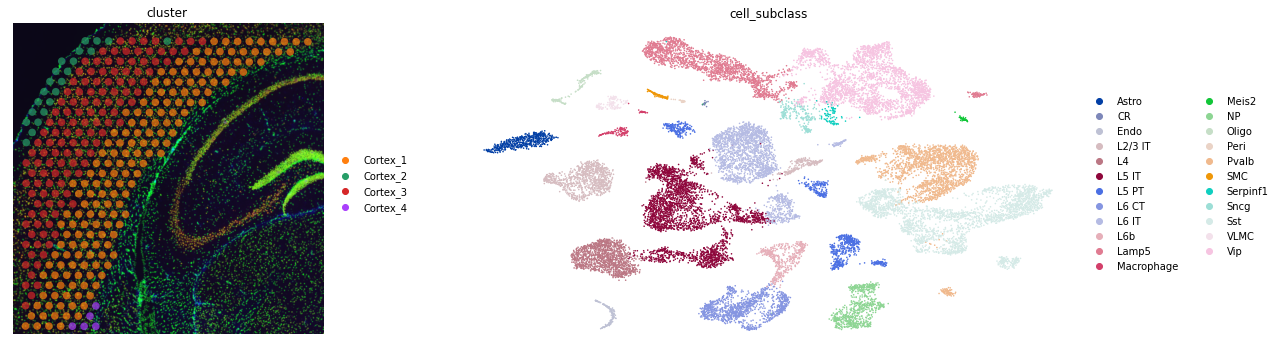

In [3]:
fig, axs = plt.subplots(1, 2, figsize=(20, 5))
sc.pl.spatial(
    adata_st, color="cluster", alpha=0.7, frameon=False, show=False, ax=axs[0]
)
sc.pl.umap(
    adata_sc, color="cell_subclass", size=10, frameon=False, show=False, ax=axs[1]
)
plt.tight_layout()

As mentioned before, we are interested in segmenting single nuclei under each spot in the Visium dataset. Squidpy makes it possible with two lines of python code:
- `squidpy.im.process` applies smoothing as a pre-processing step
- `squidpy.im.segment` computes segmentation masks with watershed algorithm

In [5]:
sq.im.process(img=img, layer="image", method="smooth")
sq.im.segment(
    img=img,
    layer="image_smooth",
    method="watershed",
    channel=0,
)

Let's visualize the results for an inset

<ipython-input-6-e112601fb82e>:41: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("plasma"))
  cmap.set_under(color="black")


Text(0.5, 1.0, 'Nucleous segmentation')

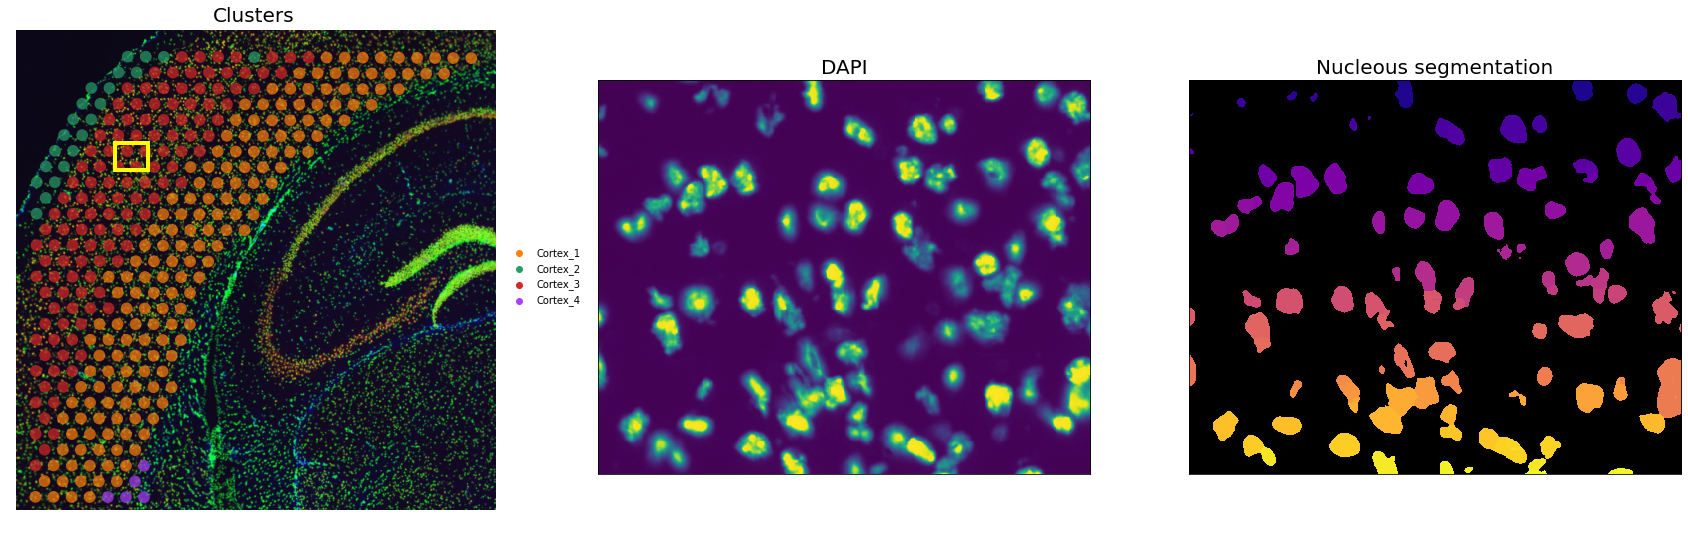

In [6]:
inset_y = 1500
inset_x = 1700
inset_sy = 400
inset_sx = 500

fig, axs = plt.subplots(1, 3, figsize=(30, 10))
sc.pl.spatial(
    adata_st, color="cluster", alpha=0.7, frameon=False, show=False, ax=axs[0], title=""
)
axs[0].set_title("Clusters", fontdict={"fontsize": 20})
sf = adata_st.uns["spatial"]["V1_Adult_Mouse_Brain_Coronal_Section_2"]["scalefactors"][
    "tissue_hires_scalef"
]
rect = mpl.patches.Rectangle(
    (inset_y * sf, inset_x * sf),
    width=inset_sx * sf,
    height=inset_sy * sf,
    ec="yellow",
    lw=4,
    fill=False,
)
axs[0].add_patch(rect)

axs[0].axes.xaxis.label.set_visible(False)
axs[0].axes.yaxis.label.set_visible(False)

axs[1].imshow(
    img["image"][inset_y : inset_y + inset_sy, inset_x : inset_x + inset_sx, 0] / 65536,
    interpolation="none",
)
axs[1].grid(False)
axs[1].set_xticks([])
axs[1].set_yticks([])
axs[1].set_title("DAPI", fontdict={"fontsize": 20})

crop = img["segmented_watershed"][
    inset_y : inset_y + inset_sy, inset_x : inset_x + inset_sx
].values
crop = skimage.segmentation.relabel_sequential(crop)[0]
cmap = plt.cm.plasma
cmap.set_under(color="black")
axs[2].imshow(crop, interpolation="none", cmap=cmap, vmin=0.001)
axs[2].grid(False)
axs[2].set_xticks([])
axs[2].set_yticks([])
axs[2].set_title("Nucleous segmentation", fontdict={"fontsize": 20})

We can appreciate that despite some false positive, the nuclei segmentation worked discretely well.

We then need to extract some image features useful for the deconvolution task downstream. Specifically, we will need:
- the number of unique segmentation objects (i.e. nuclei) under each spot.
- the coordinates of the centroids of the segmentation object.

It will become clear later how we will be using them.

In [7]:
# define image layer to use for segmentation
features_kwargs = {
    "segmentation": {
        "label_layer": "segmented_watershed",
        "props": ["label", "centroid"],
        "channels": [1, 2],
    }
}
# calculate segmentation features
sq.im.calculate_image_features(
    adata_st,
    img,
    layer="image",
    key_added="image_features",
    features_kwargs=features_kwargs,
    features="segmentation",
    mask_circle=True,
)

/Users/giovanni.palla/miniconda3/envs/spatial/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/Users/giovanni.palla/Projects/squidpy/squidpy/im/_feature_mixin.py:333: RuntimeWarning: invalid value encountered in true_divide
  y = (y - np.min(y)) / (np.max(y) - np.min(y))
/Users/giovanni.palla/Projects/squidpy/squidpy/im/_feature_mixin.py:334: RuntimeWarning: invalid value encountered in true_divide
  x = (x - np.min(x)) / (np.max(x) - np.min(x))


We can visualize the total number of object under each spot with scanpy.

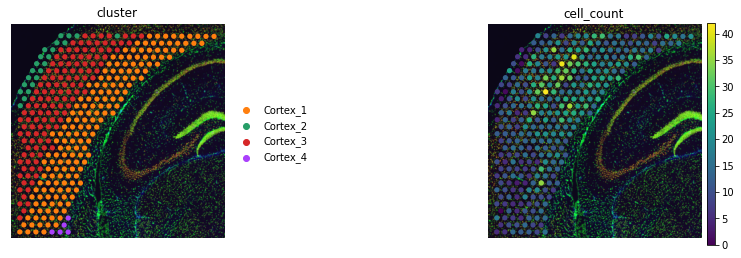

In [8]:
adata_st.obs["cell_count"] = adata_st.obsm["image_features"]["segmentation_label"]
sc.pl.spatial(adata_st, color=["cluster", "cell_count"], frameon=False)

### Deconvolution and mapping
At this stage, we have all we need for the deconvolution task. First , we need to find a set of common genes the single cell and spatial datasets. We will use the intersection of the highly variable genes.

In [9]:
genes_sc = adata_sc[:, adata_sc.var.highly_variable == True].var_names.values
genes_st = adata_st[:, adata_st.var.highly_variable == True].var_names.values
genes = list(set(genes_sc).intersection(set(genes_st)))
len(genes)

/Users/giovanni.palla/miniconda3/envs/spatial/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/Users/giovanni.palla/miniconda3/envs/spatial/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


0

We then assign the normalized count data to two new variables: S and G.

Most of the code that follows was taken from the [original Tangram tutorial](https://github.com/broadinstitute/Tangram/blob/master/example/mapping-visium-example.ipynb)

In [69]:
S = np.array(adata_sc[:, genes].X.todense(), dtype=np.float32)
G = np.array(adata_st[:, genes].X.todense(), dtype=np.float32)
d = np.array(adata_st.obs.cell_count) / adata_st.obs.cell_count.sum()

Now we are ready to instantiate the model object and its hyper parameters. Note that we are loading `torch` and training the model on a GPU. However, it's also possible to train it on cpu, it will just be slower.

In [70]:
# set device and hyper params
import torch

device = torch.device("cuda:0")
hyperparm = {
    "lambda_d": 1,
    "lambda_g1": 1,
    "lambda_g2": 0,
    "lambda_r": 0,
    "lambda_count": 1,
    "lambda_f_reg": 1,
}
learning_rate = 0.01
num_epochs = 6000

In [71]:
mapper = tg.mapping_optimizer.MapperConstrained(
    S=S,
    G=G,
    d=d,
    device=device,
    **hyperparm,
    target_count=adata_st.obs.cell_count.sum()
)

In [72]:
output, F_out = mapper.train(learning_rate=learning_rate, num_epochs=num_epochs)

0.12073366343975067 0.3197985589504242 nan 5792.6416015625 4482.66259765625
0.01641971245408058 0.3907710611820221 nan 1231.90966796875 3898.81689453125
0.01267784833908081 0.5090330243110657 nan 5.5302734375 3316.532958984375
0.0103087667375803 0.5762874484062195 nan 2.392578125 2988.073974609375
0.008803249336779118 0.611636757850647 nan 7.08447265625 2610.05029296875
0.007957302033901215 0.6282228827476501 nan 3.650390625 2226.38916015625
0.007543237879872322 0.6348501443862915 nan 2.2060546875 1866.790771484375
0.007375326007604599 0.6372743248939514 nan 0.3125 1554.5706787109375
0.007271717768162489 0.637952983379364 nan 3.81689453125 1293.0830078125
0.007222995162010193 0.6380195021629333 nan 1.2177734375 1082.93896484375
0.007215286139398813 0.6378701329231262 nan 0.34375 914.8742065429688
0.007206127978861332 0.637661874294281 nan 0.15234375 780.617919921875
0.0072155664674937725 0.6375064849853516 nan 0.2080078125 674.6494750976562
0.0072113825008273125 0.6373942494392395 nan 

As a first result, we can take the average of the mapped cells and computes proportions from it. The following functions computes the proportions from the Tangram object result, and store them in the spatial anndata object. We can appreciate how average results already give a sense of the success of the deconvolution step. Cortical layers are indeed at higher proportions in the correct regions in the tissue. Of course some layers seems to be better resolved then others. A more refined gene selection step could be of help in this case.

In [73]:
def comp2adata(tangram_res: AnnData, adata_spatial: AnnData):
    """
    Compute cell-type proportions from Tangram results,
    and assign them to the spatial adata
    """
    comp = np.zeros(
        (tangram_res.shape[1], tangram_res.obs.cell_subclass.cat.categories.shape[0])
    )

    for i, c in enumerate(tangram_res.obs.cell_subclass.cat.categories):
        comp[:, i] = tangram_res[tangram_res.obs.cell_subclass == c].X.sum(0)
    comp = comp / comp.sum(1).reshape(-1, 1)
    comp_df = pd.DataFrame(
        comp,
        columns=tangram_res.obs.cell_subclass.cat.categories,
        index=adata_spatial.obs.index,
    )

    adata_spatial.obs = pd.concat([adata_spatial.obs, comp_df], axis=1)
    return

In [74]:
ad_map = AnnData(output)
ad_map.obs["cell_subclass"] = adata_sc.obs.cell_subclass.values

In [75]:
comp2adata(ad_map, adata_st)

/home/icb/giovanni.palla/miniconda3/envs/spatial/lib/python3.8/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])


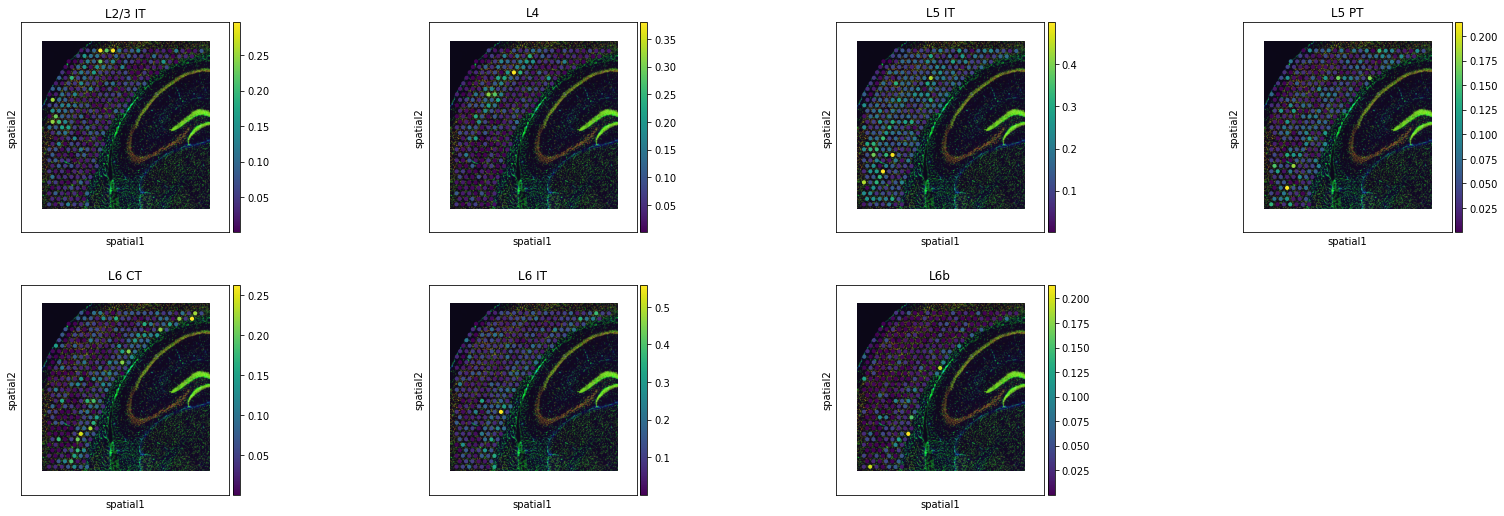

In [77]:
sc.pl.spatial(
    adata_st,
    color=["L2/3 IT", "L4", "L5 IT", "L5 PT", "L6 CT", "L6 IT", "L6b"],
)

And here it comes the key part, where we will use the results of the previous deconvolution steps. Previosuly, we computed the absolute numbers of unique segmentation objects under each spot, together with their centroids. Let's extract them in the right format useful for Tangram.

In the resulting dataframe, each row represents a single segmenation object (therefore a single nuclei). We also have the image coordinates as well as the unique centroids ID, which is a string that contains both the spot ID and a numerical index.

In [205]:
centroids = adata_st.obsm["image_features"][["segmentation_centroid"]].copy()
centroids["centroids_idx"] = [
    np.array([f"{k}_{j}" for j in np.arange(i)], dtype="object")
    for k, i in zip(
        adata_st.obs.index.values,
        adata_st.obs.cell_count.values,
    )
]
centroids_idx = centroids.explode("centroids_idx")
centroids_coords = centroids.explode("segmentation_centroid")
segmentation_df = pd.DataFrame(
    centroids_coords["segmentation_centroid"].to_list(),
    columns=["y", "x"],
    index=centroids_coords.index,
)
segmentation_df["centroids"] = centroids_idx["centroids_idx"].values
segmentation_df.index.set_names("spot_idx", inplace=True)
segmentation_df.reset_index(
    drop=False,
    inplace=True,
)
segmentation_df

,spot_idx,y,x,centroids
0,AAATGGCATGTCTTGT-1,5304.000000,731.000000,AAATGGCATGTCTTGT-1_0
1,AAATGGCATGTCTTGT-1,5323.118960,727.044256,AAATGGCATGTCTTGT-1_1
2,AAATGGCATGTCTTGT-1,5335.048316,716.818254,AAATGGCATGTCTTGT-1_2
3,AAATGGCATGTCTTGT-1,5333.475064,723.037138,AAATGGCATGTCTTGT-1_3
4,AAATGGCATGTCTTGT-1,5342.625256,566.636665,AAATGGCATGTCTTGT-1_4
...,...,...,...,...
5080,TTGTTAGCAAATTCGA-1,1735.311472,2800.246454,TTGTTAGCAAATTCGA-1_22
5081,TTGTTAGCAAATTCGA-1,1761.621120,2723.313599,TTGTTAGCAAATTCGA-1_23
5082,TTGTTAGCAAATTCGA-1,1762.928430,2731.843522,TTGTTAGCAAATTCGA-1_24
5083,TTGTTAGCAAATTCGA-1,1763.491123,2811.891481,TTGTTAGCAAATTCGA-1_25


The folllowing code is taken from the Tangram tutorial. Essentially we are mapping the cell types proportions computed before to single segmentation objects.

In [206]:
# create a dataframe x, y, cell count for each voxel, and cell centroids for each voxel
df_vox_cells = pd.DataFrame(
    {
        "x": adata_st.obsm["spatial"][:, 1],
        "y": adata_st.obsm["spatial"][:, 0],
        "cell_n": adata_st.obs.cell_count,
        "centroids": centroids["centroids_idx"],
    }
)
# get the most probable voxel for each cell
resulting_voxels = np.argmax(output, axis=1)
# create a list with filtered cells and the voxels where they have been placed with the
# highest probability a cell i is filtered if F_i > 0.5'
filtered_voxels_to_types = [
    (j, adata_sc.obs.cell_subclass[k])
    for i, j, k in zip(F_out, resulting_voxels, range(len(adata_sc)))
    if i > 0.5
]
print(len(filtered_voxels_to_types), filtered_voxels_to_types[:5])

5006 [(5, 'Pvalb'), (191, 'L4'), (231, 'L4'), (64, 'L4'), (312, 'Lamp5')]


In [207]:
df_classes = tg.utils.one_hot_encoding(adata_sc.obs.cell_subclass)
for index, i in enumerate(df_classes.columns):
    df_vox_cells[i] = 0
for k, v in filtered_voxels_to_types:
    df_vox_cells.iloc[k, df_vox_cells.columns.get_loc(v)] += 1

In [208]:
df_vox_cells

,x,y,cell_n,centroids,Pvalb,L4,Vip,L2/3 IT,Lamp5,NP,...,L5 PT,Astro,L6b,Endo,Peri,Meis2,Macrophage,CR,VLMC,SMC
AAATGGCATGTCTTGT-1,641,5393,13,"[AAATGGCATGTCTTGT-1_0, AAATGGCATGTCTTGT-1_1, A...",0,0,2,0,3,1,...,1,2,1,0,0,0,0,0,0,0
AACAACTGGTAGTTGC-1,4208,1672,17,"[AACAACTGGTAGTTGC-1_0, AACAACTGGTAGTTGC-1_1, A...",0,0,1,1,2,1,...,1,0,0,0,0,0,0,0,0,0
AACAGGAAATCGAATA-1,1117,5117,30,"[AACAGGAAATCGAATA-1_0, AACAGGAAATCGAATA-1_1, A...",1,1,3,0,1,1,...,3,1,0,0,0,0,0,0,0,0
AACCCAGAGACGGAGA-1,1101,1274,5,"[AACCCAGAGACGGAGA-1_0, AACCCAGAGACGGAGA-1_1, A...",1,0,1,0,3,0,...,1,1,0,0,0,0,0,0,0,0
AACCGTTGTGTTTGCT-1,399,4708,7,"[AACCGTTGTGTTTGCT-1_0, AACCGTTGTGTTTGCT-1_1, A...",1,1,1,0,0,0,...,0,0,0,1,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTGGATTGGGTACCAC-1,1588,3468,24,"[TTGGATTGGGTACCAC-1_0, TTGGATTGGGTACCAC-1_1, T...",2,0,5,1,0,2,...,2,0,2,0,0,0,0,0,0,0
TTGGCTCGCATGAGAC-1,3011,991,5,"[TTGGCTCGCATGAGAC-1_0, TTGGCTCGCATGAGAC-1_1, T...",0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
TTGTATCACACAGAAT-1,405,6081,25,"[TTGTATCACACAGAAT-1_0, TTGTATCACACAGAAT-1_1, T...",2,2,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
TTGTGGCCCTGACAGT-1,1830,4153,23,"[TTGTGGCCCTGACAGT-1_0, TTGTGGCCCTGACAGT-1_1, T...",3,1,1,2,1,0,...,1,0,2,0,0,0,0,0,0,0


In [209]:
cell_types_mapped = tg.utils.df_to_cell_types(df_vox_cells, list(df_classes.columns))

In [210]:
df_list = []
for k in cell_types_mapped.keys():
    df = pd.DataFrame({"centroids": np.array(cell_types_mapped[k], dtype="object")})
    df["cluster"] = k
    df_list.append(df)
cluster_df = pd.concat(df_list, axis=0)
cluster_df.reset_index(inplace=True, drop=True)

In [211]:
cluster_df

,centroids,cluster
0,AACAGGAAATCGAATA-1_0,Pvalb
1,AACCCAGAGACGGAGA-1_0,Pvalb
2,AACCGTTGTGTTTGCT-1_0,Pvalb
3,AACGATAGAAGGGCCG-1_0,Pvalb
4,AACGATAGAAGGGCCG-1_1,Pvalb
...,...,...
4382,CCATTAGCGATAATCC-1_15,VLMC
4383,CGTTTAAGCGGAGCAC-1_8,VLMC
4384,GTTCACAGGAGTCTAG-1_10,VLMC
4385,TACGTGCACTATGCTG-1_1,SMC


The result is a dataframe with two columns: the unique segementation object id, and the cell type mapped. We can merge it with the previous dataframe to obtain the coordinates, and obtain a new anndata object which can then be used for visualization.

In [212]:
merged_df = segmentation_df.merge(cluster_df, on="centroids", how="inner")
merged_df.drop(columns="spot_idx", inplace=True)
merged_df.drop_duplicates(inplace=True)
merged_df.dropna(inplace=True)
merged_df.reset_index(inplace=True, drop=True)

In [213]:
adata_segment = AnnData(np.zeros(merged_df.shape), obs=merged_df)
adata_segment.obsm["spatial"] = merged_df[["y", "x"]].to_numpy()
adata_segment.uns = adata_st.uns

/home/icb/giovanni.palla/miniconda3/envs/spatial/lib/python3.8/site-packages/anndata/_core/anndata.py:119: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


Note that the annadata object does not contain counts, but only cell type annotations, as results of the Tangram mapping. 
Nevertherless, it's convenient to create such anndata object for visualization purposes.

Below you can appreciate how each dot is now not a Visium spot anymore, but a single unique segmentation object, with the mapped cell type.

/home/icb/giovanni.palla/miniconda3/envs/spatial/lib/python3.8/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])
... storing 'cluster' as categorical


<AxesSubplot:title={'center':'cluster'}, xlabel='spatial1', ylabel='spatial2'>

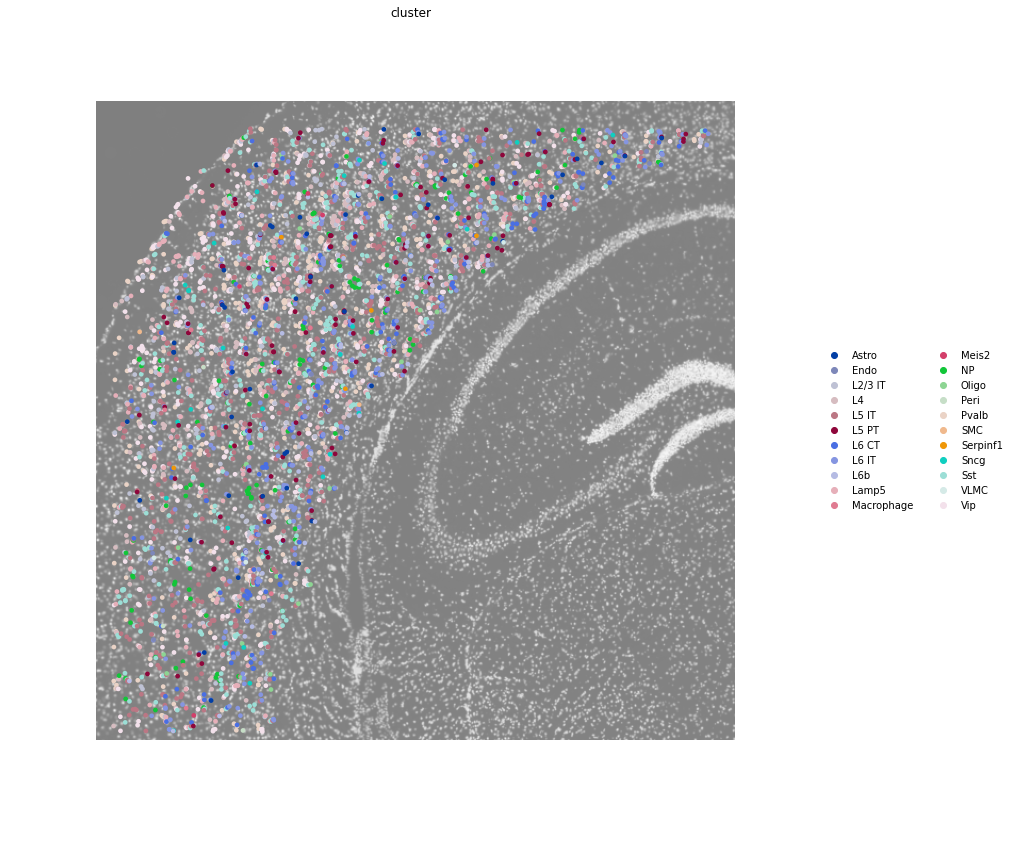

In [214]:
fig, ax = plt.subplots(1, 1, figsize=(15, 15))
sc.pl.spatial(
    adata_segment,
    color="cluster",
    size=0.3,
    show=False,
    frameon=False,
    alpha_img=0.5,
    bw=True,
    ax=ax,
)